In [ ]:
import numpy as np
from collections import deque


class Datum:
    def __init__(self, idx, v=0.0, apdict=None):
        self.idx = idx
        self.v = v
        self.apdict = apdict if apdict != None else {}


def D(di, dj):
    return np.sqrt(np.sum(np.array([np.power(i, 2) for i in (di - dj).flatten()])))

In [12]:
# initialize input space
M = np.random.randint(0, 100, (1000, 1, 2))
n = M.shape[0]

# initialize objects
data = []
for idx in range(n):
    data.append(Datum(idx))
# step 1-1: all pairs distances
for idx in range(n):
    for jdx in range(n):
        # if idx == jdx:
        #   continue
        dist = D(M[idx], M[jdx])
        data[idx].apdict[jdx] = dist
# step 1-2: V values for objects j

# precalculate denominators
denominators = []
for di in data:
    isum = 0.0
    for i in di.apdict:
        isum += di.apdict[i]
    denominators.append(isum)

# compute v values
for j, dj in enumerate(data):
    big_sum = 0.0
    for idx in dj.apdict:
        denominator = denominators[idx]
        numerator = dj.apdict[idx]
        big_sum += np.divide(numerator, denominator)
    data[j].v = big_sum
# step 1-3: sort by v value and choose k medioids
sortkey = lambda d: d.v
sorted_data = sorted(data, key=sortkey)
k = 4
medioid_idx = set([i.idx for i in sorted_data[:k]])
print(medioid_idx)

In [1]:
import numpy as np
import sys


class Datum:
    def __init__(self, idx):
        self.idx = idx
        self.v = 0.0
        self.apdict = None


# Initialize input space
M = np.random.randint(0, 100, (1000, 2))

n = M.shape[0]


distances = np.sqrt(np.sum(np.square(M[:, np.newaxis, :] - M), axis=2))

# Step 1-2: Calculate denominators efficiently
denominators = np.sum(distances, axis=1)
# Calculate v values using vectorized operations
v_values = distances / denominators[:, np.newaxis]
np.fill_diagonal(v_values, 0)  # Set diagonal values to 0
v_sums = np.sum(v_values, axis=1)
# Initialize objects using list comprehension
data = [Datum(idx) for idx in range(n)]

# Assign calculated v values to data objects
for j in range(n):
    data[j].v = v_sums[j]

# Find the indices of top k medioids using argpartition
k = 4
medioid_indices = np.argpartition(v_sums, -k)[-k:]

# Sort the medioid indices by v values
medioid_indices = medioid_indices[np.argsort(v_sums[medioid_indices])]

# Print the medioid indices
print(set(medioid_indices))

{320, 225, 60, 399}


In [8]:
def assign_clusters(dlen, mlist, distances):
    clusters = [[] for _ in mlist]

    for idx in range(dlen):
        distances_to_medioids = distances[idx, mlist]
        nearest_medioid_index = np.argmin(distances_to_medioids)
        clusters[nearest_medioid_index].append(idx)

    return clusters


def calculate_sum(clusters, mlist, distances):
    total_sum = np.sum(
        [distances[idx, midx] for midx in mlist for idx in clusters[mlist.index(midx)]]
    )
    return total_sum


def update_medioids(clusters, mlist, distances):
    new_mlist = []

    for midx in mlist:
        cluster = clusters[mlist.index(midx)]
        cluster_distances = np.sum(distances[cluster][:, cluster], axis=1)
        new_mlist.append(cluster[np.argmin(cluster_distances)])

    return new_mlist


def kmedioids(M, data, k=5, max_iter=100):
    sortkey = lambda d: d.v
    sorted_data = sorted(data, key=sortkey)
    medioid_indices = np.argpartition(np.array([d.v for d in sorted_data]), k)[:k]
    mlist = list(medioid_indices)
    n = M.shape[0]
    dlen = len(data)

    # Precompute distances
    distances = np.sqrt(np.sum(np.square(M[:, np.newaxis, :] - M), axis=2))

    total_sum = float("inf")
    for _ in range(max_iter):
        clusters = assign_clusters(dlen, mlist, distances)
        mlist = update_medioids(clusters, mlist, distances)
        new_sum = calculate_sum(clusters, mlist, distances)
        if new_sum == total_sum:
            break
        total_sum = new_sum

    return clusters, mlist


# Call kmedioids function
clusters, mlist = kmedioids(M, data, k, max_iter=100)
print(set(mlist))

{32, 16, 74, 79}


In [16]:
# step 1-4: Obtain the initial cluster result by assigning each object to the nearest medoid.
def assign_clusters(data, mlist):
    """
    assign the data to clusters
    """
    clusters = [[] for _ in mlist]
    for idx in range(n):
        di = data[idx]
        min_dist = float("inf")
        mindex = None
        for i, midx in enumerate(mlist):
            if midx == idx:
                mindex = i
                break
            if di.apdict[midx] < min_dist:
                min_dist = di.apdict[midx]
                mindex = i

        clusters[mindex].append(idx)
    return clusters


# mlist = list(medioid_idx)
# clusters = assign_clusters(data, mlist)
# step 1-5
def calculate_sum(data, clusters, mlist):
    total_sum = 0.0
    for i, midx in enumerate(mlist):
        cluster = clusters[i]
        for idx in cluster:
            total_sum += data[idx].apdict[midx]
    return total_sum


def update_medioids(data, clusters, mlist):
    new_mlist = []
    for i, midx in enumerate(mlist):
        cluster = clusters[i]
        min_dist = float("inf")
        mindex = None
        for idx in cluster:
            cdist = 0.0
            for sidx in cluster:
                cdist += data[idx].apdict[sidx]
            if cdist < min_dist:
                min_dist = cdist
                mindex = idx
        new_mlist.append(mindex)

    return new_mlist


# mlist = update_medioids(data, clusters ,mlist)
def kmedioids(M, data, k=5, max_iter=100):
    sortkey = lambda d: d.v
    sorted_data = sorted(data, key=sortkey)
    k = 5
    medioid_idx = set([i.idx for i in sorted_data[:k]])
    mlist = list(medioid_idx)
    n = M.shape[0]
    total_sum = float("inf")
    for _ in range(max_iter):
        clusters = assign_clusters(data, mlist)
        mlist = update_medioids(data, clusters, mlist)
        new_sum = calculate_sum(data, clusters, mlist)
        if new_sum == total_sum:
            break
        total_sum = new_sum
    return clusters, mlist

In [9]:
# clusters, mlist = kmedioids(M, data, k, 20)
medioids = np.array([M[idx] for idx in mlist])
for i in range(k):
    clusters[i] = np.stack(np.array([M[j] for j in clusters[i]]))
    # print(clusters[i].shape)

In [2]:
# Create a NumPy array with a ragged shape
# ragged_array = np.array(clusters)

# Save the ragged array using np.save()
np.save("data_array.npy", M)
# np.save('medioids_array.npy', medioids)

In [11]:
# Vectorized distance calculation
def D_vect(di, dj):
    return np.sqrt(np.sum(np.square(di - dj), axis=0))


msums = [0] * len(mlist)
for i, midx in enumerate(mlist):
    for pidx in clusters[i]:
        # print(M[midx].shape)
        msums[i] += D_vect(M[midx], pidx)
print(msums)

[277.4875162567725, 287.17313628818584, 183.54989617418892, 213.8484786346134]


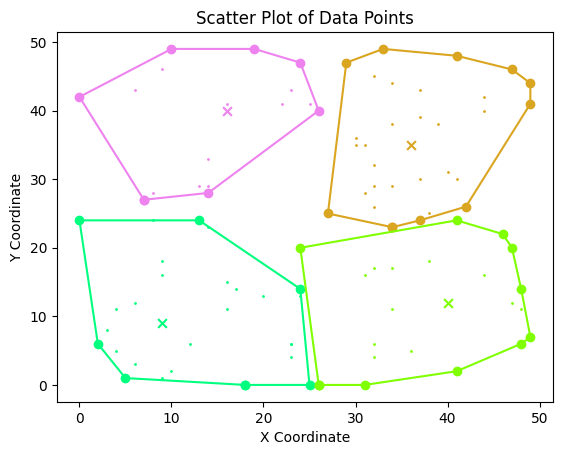

: 

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def graham_scan_convex_hull(points):
    def cross_product(p, q, r):
        return (q[0] - p[0]) * (r[1] - p[1]) - (r[0] - p[0]) * (q[1] - p[1])

    def polar_angle(p, q):
        return np.arctan2(q[1] - p[1], q[0] - p[0])

    # Find the point with the lowest y-coordinate (and leftmost if tied)
    start_point = min(points, key=lambda p: (p[1], p[0]))

    # Sort the points based on polar angles with respect to the start point
    sorted_points = sorted(
        points, key=lambda p: (polar_angle(start_point, p), -p[1], p[0])
    )

    # Initialize the convex hull with the first three sorted points
    convex_hull = [sorted_points[0], sorted_points[1], sorted_points[2]]

    # Iterate through the sorted points and construct the convex hull
    for point in sorted_points[3:]:
        while (
            len(convex_hull) >= 2
            and cross_product(convex_hull[-2], convex_hull[-1], point) <= 0
        ):
            convex_hull.pop()
        convex_hull.append(point)

    return convex_hull


# Reshape the array to (100, 2) for plotting
colors = list(set(mcolors.CSS4_COLORS))[::4]
# print(colors)
reshaped_centers = medioids.reshape(-1, 2)
cx_coords = reshaped_centers[:, 0]
cy_coords = reshaped_centers[:, 1]

for i, m in enumerate(clusters):
    reshaped_data = m.reshape(-1, 2)
    if len(m) > 2:
        convex_hull = graham_scan_convex_hull(reshaped_data)
        convex_hull.append(convex_hull[0])

        # Convert the convex hull points to a numpy array for visualization
        convex_hull_array = np.array(convex_hull)

        # Plot the original points and the convex hull
        # plt.scatter(reshaped_data[:, 0], reshaped_data[:, 1], c='blue', label='Points')
        plt.plot(
            convex_hull_array[:, 0],
            convex_hull_array[:, 1],
            c=colors[i],
            marker="o",
            label="Convex Hull",
        )

    x_coords = reshaped_data[:, 0]
    y_coords = reshaped_data[:, 1]
    plt.scatter(x_coords, y_coords, marker="o", color=colors[i], s=1)
    plt.scatter(cx_coords[i], cy_coords[i], marker="x", color=colors[i], s=40)

# Add labels and title
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatter Plot of Data Points")

# Display the plot
plt.show()

In [1]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("CUDA GPU is available")
    print("GPU Name:", tf.config.experimental.list_physical_devices("GPU")[0].name)
else:
    print("CUDA GPU is not available")

2023-08-25 15:07:53.456357: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 15:07:53.688339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
CUDA GPU is available
GPU Name: /physical_device:GPU:0


2023-08-25 15:07:56.769674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-25 15:07:56.970932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-25 15:07:56.970968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-25 15:07:58.356284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-25 15:07:58.356335: I tensorflow/compile

In [3]:
import pynvml

pynvml.nvmlInit()

num_gpus = pynvml.nvmlDeviceGetCount()
print("Number of available GPUs:", num_gpus)

for gpu_id in range(num_gpus):
    handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_id)
    gpu_name = pynvml.nvmlDeviceGetName(handle)
    print(f"GPU {gpu_id}: {gpu_name}")  # ('utf-8')}")

pynvml.nvmlShutdown()

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
from numba import cuda

# Get a list of available CUDA devices
devices = cuda.list_devices()

# Print information about each device
for device in devices:
    print("Device Name:", device.name)
    print("Device ID:", device.id)
    print("Compute Capability:", device.compute_capability)
    print("Memory Total (GB):", device.memory_total / 1024**3)  # Convert to GB
    print()

CudaSupportError: Error at driver init: Call to cuInit results in CUDA_ERROR_NO_DEVICE (100)

AttributeError: module 'Image' has no attribute 'ImageStartShapeVector'

In [8]:
import flatbuffers
import numpy as np
import MyData.Image as Image
import MyData.Data as Data

# Deserialize the serialized NumPy array
serialized_array = np.load("../../../data/images_from_structures.npy")

# Reshape the array to (256, 16384)
reshaped_array = serialized_array.reshape(256, 16384)

# Create a FlatBuffers builder
builder = flatbuffers.Builder(1024)

# Serialize each image as an Image
images = []
for img_data in reshaped_array:
    # Convert the image data to bytes
    byte_array = img_data.tobytes()
    Image.ImageStartDataVector(builder, len(byte_array))
    builder.head = builder.head - len(byte_array)
    builder.Bytes[builder.head : builder.head + len(byte_array)] = byte_array
    data_vector = builder.EndVector(len(byte_array))
    # Create an Image object
    Image.ImageStart(builder)
    Image.ImageAddShape(builder, 128)
    Image.ImageAddData(builder, data_vector)
    image = Image.ImageEnd(builder)

    images.append(image)

# Serialize the list of images as Data
Data.DataStartMVector(builder, len(images))
for img in reversed(images):
    builder.PrependUOffsetTRelative(img)
m_vector = builder.EndVector(len(images))

Data.DataStart(builder)
Data.DataAddM(builder, m_vector)
data = Data.DataEnd(builder)

builder.Finish(data)

# Save the FlatBuffers buffer to a file
with open("serialized_data.fb", "wb") as f:
    f.write(builder.Output())

ValueError: invalid literal for int() with base 10: b"\x00\x00@c\x02\xfaT\xbc\x00\x00\x00\x94un2\xbc\x00\x00\x00,\x1eG><\x00\x00\x00\x06\x95\x01%<\x00\x00\x00\xd3m\x9d0\xbc\x00\x00\x00\xe8,\xe5\r<\x00\x00\x00\x16\x9fP5<\x00\x00\x00\xbe?1G\xbc\x00\x00\x